In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import basinhopping, differential_evolution, dual_annealing
import logging

# Define common configurations
CONFIG = {
    'fixed_transaction_cost': 10,
    'variable_transaction_cost': 1,
    'holding_cost': 0.1,
    'loss_sales_penalty': 5,
    'demand_mean': 5,
    'demand_std': 2,
    'max_inventory': 60,
    'fixed_lead_time': 1  # Changed lead time to 1
}

# Set up logging
logging.basicConfig(level=logging.INFO)

# Define demand generator
class HalfNormalGenerator:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def next(self):
        return abs(np.random.normal(self.mean, self.std))

# Define common environment class
class SupplyChainEnvironment:
    def __init__(self, config):
        self.config = config
        self.inventory = np.random.randint(10, 20)
        self.demand_generator = HalfNormalGenerator(config['demand_mean'], config['demand_std'])
        self.fixed_lead_time = config['fixed_lead_time']
        self.reset()

    def reset(self):
        self.inventory = np.random.randint(10, 20)
        self.orders = []
        self.total_cost = 0
        self.total_filled_demand = 0
        self.total_demand = 0
        return self.inventory

    def step(self, order_quantity):
        # Process demand
        demand = int(self.demand_generator.next())
        self.total_demand += demand
        filled_demand = min(demand, self.inventory)
        self.inventory -= filled_demand
        self.total_filled_demand += filled_demand

        # Process order
        if order_quantity > 0:
            self.inventory += order_quantity
            self.orders.append(order_quantity)
        else:
            self.orders.append(0)

        # Calculate costs
        fixed_cost = self.config['fixed_transaction_cost'] if order_quantity > 0 else 0
        variable_cost = self.config['variable_transaction_cost'] * order_quantity
        holding_cost = self.config['holding_cost'] * self.inventory
        lost_sales_cost = self.config['loss_sales_penalty'] * (demand - filled_demand)
        total_cost = fixed_cost + variable_cost + holding_cost + lost_sales_cost
        self.total_cost += total_cost

        # Return new state, reward
        reward = -(total_cost)
        return self.inventory, reward

# Define DQNAgent class
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.memory = []
        self.batch_size = 64
        self.model = self._build_model()
        # Add an attribute to store training losses
        self.training_losses = []

    def _build_model(self):
        model = Sequential([
            Input(shape=(self.state_size,)),  # Explicit Input layer
            Dense(24, activation='relu'),
            Dense(24, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(0, self.action_size)
        q_values = self.model.predict(state[np.newaxis], verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        indices = np.random.choice(len(self.memory), self.batch_size, replace=False)
        minibatch = [self.memory[i] for i in indices]

        states, targets = [], []
        for state, action, reward, next_state in minibatch:
            target = reward + self.gamma * np.amax(self.model.predict(next_state[np.newaxis], verbose=0)[0])
            target_f = self.model.predict(state[np.newaxis], verbose=0)[0]
            target_f[action] = target
            states.append(state)
            targets.append(target_f)

        # Add loss to training_losses
        history = self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)
        self.training_losses.append(history.history['loss'][0])  # Change 2
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# Updated train_evaluate_dqn_policy Function
def train_evaluate_dqn_policy(training_data, config, model_path="dqn_trained_model.h5"):
    env = SupplyChainEnvironment(config)
    state_size, action_size = 1, 10
    try:
      agent = DQNAgent(state_size, action_size)
      agent.model = tf.keras.models.load_model(model_path)
      logging.info("Loaded pre-trained model.")
    except:
      agent = DQNAgent(state_size, action_size)

    episodes = 40
    timesteps = 20

    dqn_filled, dqn_orders, dqn_costs = [], [], []
    rewards_per_episode = []

    for episode in range(episodes):
        state = np.array([env.reset()])
        total_reward = 0

        for _ in range(timesteps):
            dqn_action = agent.act(state)
            next_state, reward = env.step(dqn_action)
            next_state = np.array([next_state])
            agent.remember(state, dqn_action, reward, next_state)
            state = next_state
            total_reward += reward

            dqn_filled.append(min(env.total_demand, env.inventory))
            dqn_orders.append(dqn_action)
            dqn_costs.append((env.total_cost, reward, env.inventory))

            agent.replay()

        rewards_per_episode.append(total_reward)
        # Print the reward for each episode
        print(f"Training Episode {episode + 1}/{episodes} total reward for this episode: {total_reward}")
    agent.model.save(model_path)
    logging.info("Model saved.")




    # Plot training loss curve
    plt.figure(figsize=(8, 5))
    plt.plot(agent.training_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('DQN Training Loss Curve')
    plt.legend()
    plt.show()  # Change 4

    # Plot episodic reward curve
    plt.figure(figsize=(8, 5))
    plt.plot(rewards_per_episode, label='Episodic Rewards')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title('Episodic Reward Curve')
    plt.legend()
    plt.show()  # Change 5

    return agent, rewards_per_episode, dqn_filled, dqn_orders, dqn_costs

# Generate and save training data
def generate_data(episodes, timesteps, config):
    env = SupplyChainEnvironment(config)
    data = []

    for _ in range(episodes):
        state = env.reset()
        for _ in range(timesteps):
            demand = env.demand_generator.next()
            data.append([state, demand])
    df = pd.DataFrame(data, columns=['State', 'Demand'])
    print(" data has been successfully GENERATED")
    return df




In [ ]:
# Main Execution
training_data = generate_data(40, 20, CONFIG)
training_data.to_excel("training_data.xlsx", index=False)
training_data = pd.read_excel("training_data.xlsx")
logging.info("Training data generated.")




 data has been successfully GENERATED


In [ ]:
# prompt: print first 5 rows of training data excel

print(training_data.head())


   State    Demand
0     11  5.407576
1     11  6.515866
2     11  4.841701
3     11  1.906303
4     11  4.663161


Training Episode 1/40 total reward for this episode: -354.9
Training Episode 2/40 total reward for this episode: -342.4
Training Episode 3/40 total reward for this episode: -320.79999999999995
Training Episode 4/40 total reward for this episode: -303.59999999999997
Training Episode 5/40 total reward for this episode: -338.1
Training Episode 6/40 total reward for this episode: -283.09999999999997
Training Episode 7/40 total reward for this episode: -244.29999999999998
Training Episode 8/40 total reward for this episode: -327.59999999999997
Training Episode 9/40 total reward for this episode: -380.9
Training Episode 10/40 total reward for this episode: -310.69999999999993
Training Episode 11/40 total reward for this episode: -303.29999999999995
Training Episode 12/40 total reward for this episode: -384.3
Training Episode 13/40 total reward for this episode: -349.0
Training Episode 14/40 total reward for this episode: -332.70000000000005
Training Episode 15/40 total reward for this episod

Training Episode 40/40 total reward for this episode: -181.9


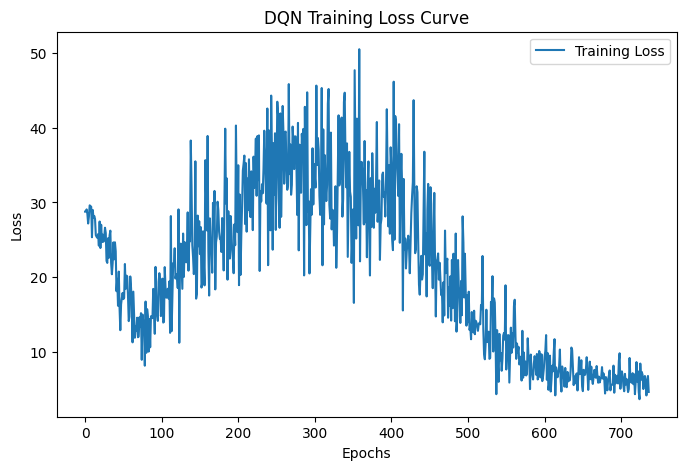

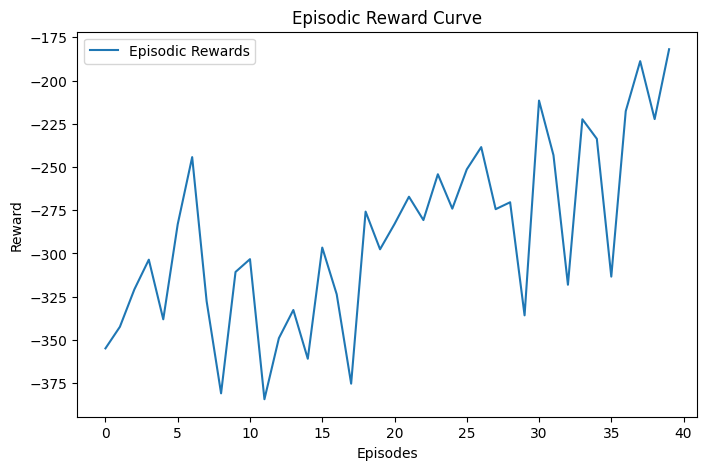

In [ ]:
dqn_agent, rewards_per_episode, dqn_filled, dqn_orders, dqn_costs = train_evaluate_dqn_policy(training_data, CONFIG)
logging.info("DQN Policy trained.")

In [ ]:
# Evaluate DQN policy on test data
def evaluate_dqn_policy_on_test_data(dqn_agent, config, test_data):
    env = SupplyChainEnvironment(config)
    dqn_filled, dqn_orders, dqn_rewards, dqn_costs = [], [], [], []

    for _, row in test_data.iterrows():
        state = np.array([row['State']])
        demand = row['Demand']
        dqn_action = dqn_agent.act(state)
        next_state, reward = env.step(dqn_action)

        dqn_filled.append(min(demand, env.inventory))
        dqn_orders.append(dqn_action)
        dqn_rewards.append(reward)
        dqn_costs.append((env.total_cost, reward, env.inventory))

    return dqn_filled, dqn_orders, dqn_rewards, dqn_costs

dqn_filled_test, dqn_orders_test, dqn_rewards_test, dqn_costs_test = evaluate_dqn_policy_on_test_data(dqn_agent, CONFIG, test_data)
logging.info("Evaluation of DQN Policy on test data completed.")



In [ ]:
#SQ RS
# Define SQ Policy
class sQInventoryPolicy:
    def __init__(self, s, Q):
        self.s = s
        self.Q = Q

    def order(self, inventory):
        if inventory <= self.s:
            return self.Q
        return 0

# Define RS Policy
class RSInventoryPolicy:
    def __init__(self, R, S):
        self.R = R
        self.S = S

    def order(self, inventory, timestep):
        if timestep % self.R == 0 and inventory <= self.S:
            return self.S - inventory
        return 0

# SQ Objective Function
def sq_objective(params, training_data, config):
    s, Q = params
    env = SupplyChainEnvironment(config)
    total_cost = 0
    policy = sQInventoryPolicy(s, Q)

    for _, row in training_data.iterrows():
        state, demand = row['State'], row['Demand']
        order = policy.order(state)
        _, reward = env.step(order)
        total_cost -= reward

    return total_cost

# RS Objective Function
def rs_objective(params, training_data, config):
    R, S = params
    env = SupplyChainEnvironment(config)
    total_cost = 0
    policy = RSInventoryPolicy(R, S)

    for timestep, row in enumerate(training_data.itertuples()):
        state, demand = row.State, row.Demand
        order = policy.order(state, timestep)
        _, reward = env.step(order)
        total_cost -= reward

    return total_cost

# Train and evaluate SQ policy with Scipy Optimizers
def train_evaluate_sq_policy_optimized(training_data, config):
    bounds = [(1, config['max_inventory'] // 3), (10, config['max_inventory'])]  # Adjusted bounds
    result = differential_evolution(
        sq_objective,
        bounds=bounds,
        args=(training_data, config)
    )
    s, Q = result.x
    best_cost = result.fun
    return int(s), int(Q), best_cost

# Train and evaluate RS policy with Scipy Optimizers
def train_evaluate_rs_policy_optimized(training_data, config):
    bounds = [(1, 10), (10, config['max_inventory'])]  # Adjusted bounds
    result = dual_annealing(
        rs_objective,
        bounds=bounds,
        args=(training_data, config)
    )
    R, S = result.x
    best_cost = result.fun
    return int(R), int(S), best_cost

# Updated evaluate_policies_sq_and_rs_on_test_data Function
def evaluate_policies_sq_and_rs_on_test_data(best_s, best_Q, best_R, best_S, config, test_data):
    env = SupplyChainEnvironment(config)
    demand, sq_filled, rs_filled = [], [], []
    lost_demand = []
    sq_stock, rs_stock, safety_stock = [], [], []
    sq_orders, rs_orders = [], []
    sq_costs, rs_costs = [], []

    sq_policy = sQInventoryPolicy(best_s, best_Q)
    rs_policy = RSInventoryPolicy(best_R, best_S)

    for timestep, row in test_data.iterrows():
        demand_value = row['Demand']
        demand.append(demand_value)

        sq_order = sq_policy.order(env.inventory)
        sq_inventory, sq_reward = env.step(sq_order)
        sq_filled.append(min(demand_value, sq_inventory))
        sq_orders.append(sq_order)
        sq_stock.append(sq_inventory)
        lost_demand.append(demand_value - min(demand_value, sq_inventory))
        safety_stock.append(max(0, CONFIG['max_inventory'] - sq_inventory))
        sq_costs.append((env.total_cost, sq_reward, sq_inventory))

        rs_order = rs_policy.order(env.inventory, timestep)
        rs_inventory, rs_reward = env.step(rs_order)
        rs_filled.append(min(demand_value, rs_inventory))
        rs_orders.append(rs_order)
        rs_stock.append(rs_inventory)
        rs_costs.append((env.total_cost, rs_reward, rs_inventory))

    return (
        demand, sq_filled, rs_filled, lost_demand,
        sq_stock, rs_stock, safety_stock,
        sq_orders, rs_orders,
        sq_costs, rs_costs
    )





In [ ]:
best_s, best_Q, best_cost_sq = train_evaluate_sq_policy_optimized(training_data, CONFIG)
logging.info(f"Best SQ Policy: s={best_s}, Q={best_Q}, Cost={best_cost_sq}")

best_R, best_S, best_cost_rs = train_evaluate_rs_policy_optimized(training_data, CONFIG)
logging.info(f"Best RS Policy: R={best_R}, S={best_S}, Cost={best_cost_rs}")


print(f"Best SQ Policy: s={best_s}, Q={best_Q}, Cost={best_cost_sq}")
print(f"Best RS Policy: R={best_R}, S={best_S}, Cost={best_cost_rs}")

Best SQ Policy: s=10, Q=11, Cost=16277.61451482835
Best RS Policy: R=3, S=51, Cost=16948.145757335424


In [ ]:
# Generate test data
test_data = generate_data(10, 20, CONFIG)
test_data.to_excel("test_data.xlsx", index=False)
test_data = pd.read_excel("test_data.xlsx")
logging.info("Test data generated.")



 data has been successfully GENERATED


In [ ]:
# prompt: print first 5 rows of test data

import pandas as pd

# Assuming 'test_data.xlsx' is in the current directory or you provide the correct path
try:
    test_data = pd.read_excel("test_data.xlsx")
    print(test_data.head())
except FileNotFoundError:
    print("Error: 'test_data.xlsx' not found. Please ensure the file exists in the current directory or provide the correct path.")
except Exception as e:
    print(f"An error occurred: {e}")

   State    Demand
0     17  5.866867
1     17  2.915773
2     17  3.076315
3     17  5.646409
4     17  3.350810


In [ ]:
# prompt:  print s,Q,R,S,total of sq_costs, total of rs_costs for test data using function  evaluate_policies_sq_and_rs_on_test_data

import pandas as pd

# Assuming 'test_data.xlsx' is in the current directory or you provide the correct path
try:
    test_data = pd.read_excel("test_data.xlsx")
    #print(test_data.head())
except FileNotFoundError:
    print("Error: 'test_data.xlsx' not found. Please ensure the file exists in the current directory or provide the correct path.")
except Exception as e:
    print(f"An error occurred: {e}")

#Evaluate SQ and RS policies on test data
(
    demand, sq_filled, rs_filled, lost_demand,
    sq_stock, rs_stock, safety_stock,
    sq_orders, rs_orders,
    sq_costs, rs_costs
) = evaluate_policies_sq_and_rs_on_test_data(best_s, best_Q, best_R, best_S, CONFIG, test_data)

print(f"s = {best_s}, Q = {best_Q}, R = {best_R}, S = {best_S}")
print("Total sq_costs:", sum(cost[0] for cost in sq_costs))
print("Total rs_costs:", sum(cost[0] for cost in rs_costs))

s = 10, Q = 11, R = 3, S = 51
Total sq_costs: 391652.4
Total rs_costs: 394887.1


In [ ]:
def organize_data(
    rewards_per_episode, dqn_filled, dqn_orders, dqn_costs,
    demand, sq_filled, rs_filled, lost_demand,
    sq_stock, rs_stock, safety_stock, sq_orders, rs_orders, sq_costs, rs_costs
):
    data = {
        "DQN": {
            "Rewards": pd.DataFrame({"Episode": range(1, len(rewards_per_episode) + 1), "Reward": rewards_per_episode}),
            "Orders": pd.DataFrame({"Order": dqn_orders}),
            "Costs": pd.DataFrame(dqn_costs, columns=["Total Cost", "Reward", "Inventory"])
        },
        "SQ": {
            "Filled": pd.DataFrame({"Demand": demand, "Filled": sq_filled}),
            "Orders": pd.DataFrame({"Orders": sq_orders}),
            "Costs": pd.DataFrame(sq_costs, columns=["Total Cost", "Reward", "Inventory"])
        },
        "RS": {
            "Filled": pd.DataFrame({"Demand": demand, "Filled": rs_filled}),
            "Orders": pd.DataFrame({"Orders": rs_orders}),
            "Costs": pd.DataFrame(rs_costs, columns=["Total Cost", "Reward", "Inventory"])
        }
    }
    return data


# Organize data
data = organize_data(
    rewards_per_episode, dqn_filled, dqn_orders, dqn_costs,
    demand, sq_filled, rs_filled, lost_demand,
    sq_stock, rs_stock, safety_stock, sq_orders, rs_orders, sq_costs, rs_costs
)
logging.info("Data organized.")

In [ ]:
data

{'DQN': {'Rewards':     Episode  Reward
  0         1  -354.9
  1         2  -342.4
  2         3  -320.8
  3         4  -303.6
  4         5  -338.1
  5         6  -283.1
  6         7  -244.3
  7         8  -327.6
  8         9  -380.9
  9        10  -310.7
  10       11  -303.3
  11       12  -384.3
  12       13  -349.0
  13       14  -332.7
  14       15  -360.9
  15       16  -296.6
  16       17  -323.6
  17       18  -375.3
  18       19  -275.8
  19       20  -297.6
  20       21  -283.0
  21       22  -267.2
  22       23  -280.7
  23       24  -254.2
  24       25  -274.1
  25       26  -251.4
  26       27  -238.5
  27       28  -274.4
  28       29  -270.4
  29       30  -335.8
  30       31  -211.6
  31       32  -243.2
  32       33  -318.1
  33       34  -222.4
  34       35  -233.7
  35       36  -313.4
  36       37  -217.7
  37       38  -188.8
  38       39  -222.3
  39       40  -181.9,
  'Orders':      Order
  0        8
  1        2
  2        0
  3        2
  4 

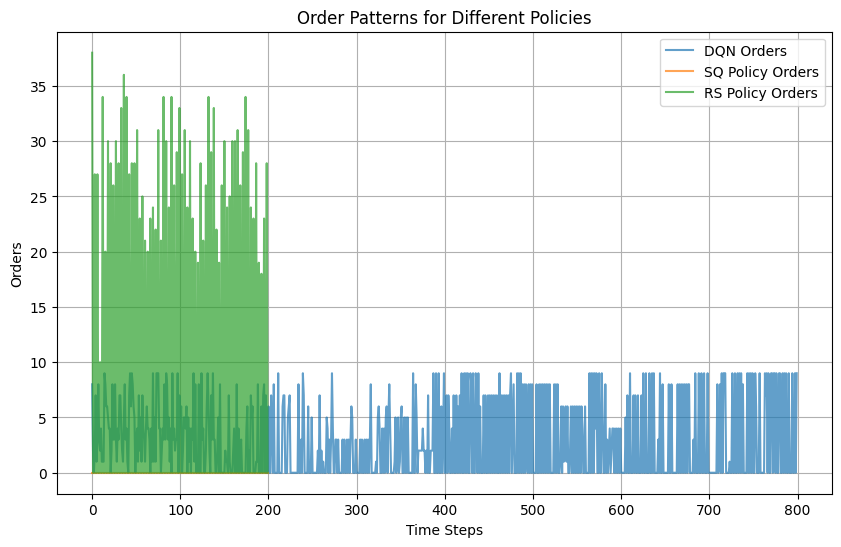

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data["DQN"]["Orders"].index, data["DQN"]["Orders"]["Order"], label="DQN Orders", alpha=0.7)
plt.plot(data["SQ"]["Orders"].index, data["SQ"]["Orders"]["Orders"], label="SQ Policy Orders", alpha=0.7)
plt.plot(data["RS"]["Orders"].index, data["RS"]["Orders"]["Orders"], label="RS Policy Orders", alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("Orders")
plt.title("Order Patterns for Different Policies")
plt.legend()
plt.grid()
plt.show()


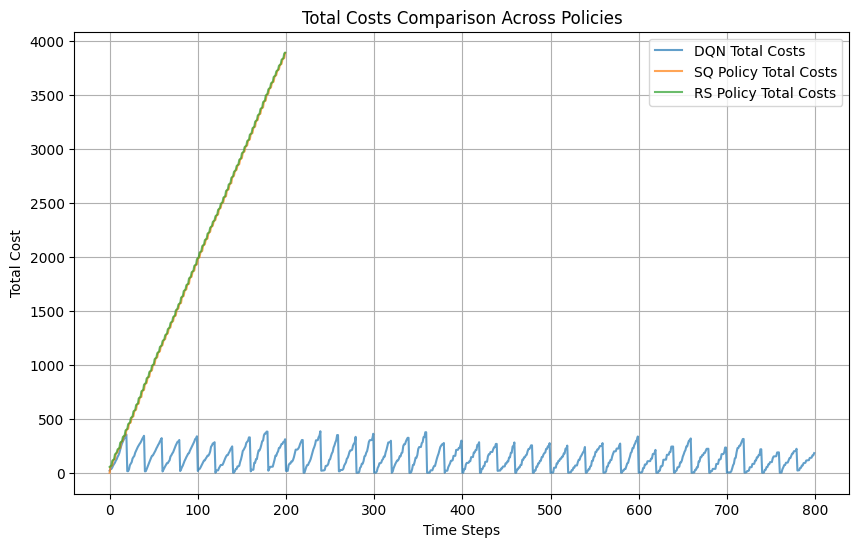

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data["DQN"]["Costs"]["Total Cost"], label="DQN Total Costs", alpha=0.7)
plt.plot(data["SQ"]["Costs"]["Total Cost"], label="SQ Policy Total Costs", alpha=0.7)
plt.plot(data["RS"]["Costs"]["Total Cost"], label="RS Policy Total Costs", alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("Total Cost")
plt.title("Total Costs Comparison Across Policies")
plt.legend()
plt.grid()
plt.show()


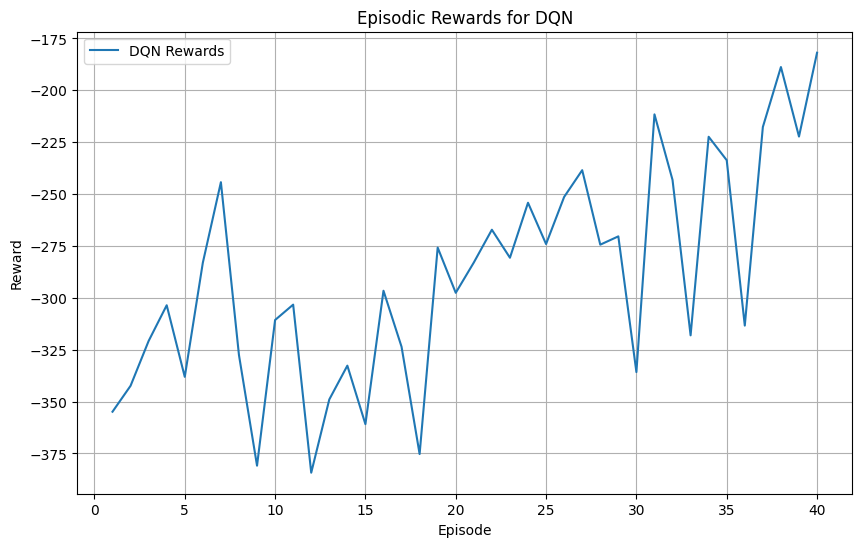

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data["DQN"]["Rewards"]["Episode"], data["DQN"]["Rewards"]["Reward"], label="DQN Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episodic Rewards for DQN")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Display results
print("\nTest Data Results:")
print(f"SQ Policy - Filled Demand: {sum(sq_filled)}, Lost Demand: {sum(lost_demand)}, Total Cost: {sq_costs[-1][0]}")
print(f"RS Policy - Filled Demand: {sum(rs_filled)}, Lost Demand: {sum(lost_demand)}, Total Cost: {rs_costs[-1][0]}")
print(f"DQN Policy - Filled Demand: {sum(dqn_filled_test)}, Total Cost: {dqn_costs_test[-1][0]}")